# 2. 一般化線形回帰

In [17]:
import copy
import japanize_matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from matplotlib.pyplot import imshow
from numpy.random import randn
from scipy import stats

**第1章より**

In [18]:
def soft_th(lam, x):
    return np.sign(x) * np.maximum(np.abs(x) - lam, np.zeros(1))

In [19]:
def linear_lasso(X, y, lam=0, beta=None):
    n, p = X.shape
    if beta is None:
        beta = np.zeros(p)
    X, y, X_bar, X_sd, y_bar = centralize(X, y)   # 中心化（下記参照）
    eps = 1
    beta_old = copy.copy(beta)
    while eps > 0.00001:    # このループの収束を待つ
        for j in range(p):
            r = y
            for k in range(p):
                if j != k:
                    r = r - X[:, k] * beta[k]
            z = (np.dot(r, X[:, j]) / n) / (np.dot(X[:, j], X[:, j]) / n)
            beta[j] = soft_th(lam, z)
        eps = np.linalg.norm(beta - beta_old, 2)
        beta_old = copy.copy(beta)
    beta = beta / X_sd   # 各変数の係数を正規化前のものに戻す
    beta_0 = y_bar - np.dot(X_bar, beta)
    return beta, beta_0

In [20]:
def centralize(X0, y0, standardize=True):
    X = copy.copy(X0)
    y = copy.copy(y0)
    n, p = X.shape
    X_bar = np.zeros(p)                   # Xの各列の平均
    X_sd = np.zeros(p)                    # Xの各列の標準偏差
    for j in range(p):
        X_bar[j] = np.mean(X[:, j])
        X[:, j] = X[:, j] - X_bar[j]      # Xの各列の中心化
        X_sd[j] = np.std(X[:, j])
        if standardize is True:
            X[:, j] = X[:, j] / X_sd[j]   # Xの各列の標準化
    if np.ndim(y) == 2:
        K = y.shape[1]
        y_bar = np.zeros(K)               # yの平均
        for k in range(K):
            y_bar[k] = np.mean(y[:, k])
            y[:, k] = y[:, k] - y_bar[k]  # yの中心化
    else:                                 # yがベクトルの場合
        y_bar = np.mean(y)
        y = y - y_bar
    return X, y, X_bar, X_sd, y_bar

## 2.1　線形回帰のLassoの一般化

In [21]:
def W_linear_lasso(X, y, W, lam=0):
    n, p = X.shape
    X_bar = np.zeros(p)
    for k in range(p):
        X_bar[k] = np.sum(np.dot(W, X[:, k])) / np.sum(W)
        X[:, k] = X[:, k] - X_bar[k]
    y_bar = np.sum(np.dot(W, y)) / np.sum(W)
    y = y - y_bar
    L = np.linalg.cholesky(W)  #
#   L = np.sqrt(W)
    u = np.dot(L, y)
    V = np.dot(L, X)
    beta, beta_0 = linear_lasso(V, u, lam)
    beta_0 = y_bar - np.dot(X_bar, beta)
    return beta_0, beta

## 2.2　2値のロジスティック回帰

### 例11

In [22]:
def f(x):
    return np.exp(beta_0 + np.dot(beta, x)) / (1 + np.exp(beta_0 + np.dot(beta, x)))

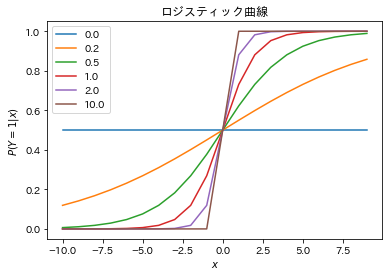

In [23]:
beta_0 = 0
beta_seq = np.array([0, 0.2, 0.5, 1, 2, 10])
m = len(beta_seq)
x = np.arange(-10, 10)
for i in range(m):
    beta = beta_seq[i]
    plt.plot(x, f(x), label=beta_seq[i])
plt.title("ロジスティック曲線")
plt.xlabel("$x$")
plt.ylabel("$P(Y=1|x)$")
plt.legend()

### 例12

In [24]:
# データ生成
N = 100
p = 2
X = np.random.randn(N, p)
X = np.concatenate([np.ones(N).reshape(N, 1), X], axis=1)
beta = np.random.randn(p+1)
y = np.zeros(N)
s = np.dot(X, beta)
prob = 1 / (1 + np.exp(s))
for i in range(N):
    if np.random.rand(1) > prob[i]:
        y[i] = 1
    else:
        y[i] = -1
beta

array([ 0.5999302 , -0.94731014,  0.46968005])

In [27]:
# 最尤推定値の計算
beta = np.inf
gamma = np.random.randn(p + 1)
while np.sum((beta - gamma) ** 2) > 0.001:
    beta = gamma.copy()
    s = np.dot(X, beta)
    v = np.exp(-s * y)
    u = y * v / (1 + v)
    w = v / (1 + v) ** 2
    z = s + u / w
    W = np.diag(w)
    gamma = np.dot(np.linalg.inv(X.T @ W @ X), np.dot(X.T @ W, z))       ##
    print(gamma)
beta  # 真の値。最尤法でこの値を推定したい

[ 0.36462501 -1.77799016  0.062009  ]
[ 1.12186585 -0.81327288  0.31797672]
[ 1.06533412 -1.20190911  0.33091463]
[ 1.08399005 -1.24589661  0.33794351]
[ 1.08444839 -1.24666403  0.33806029]


array([ 1.08399005, -1.24589661,  0.33794351])

In [29]:
def logistic_lasso(X, y, lam):
    p = X.shape[1]   # Xのすべて1の列を含んだ列数
    beta = np.inf
    gamma = np.random.randn(p)
    while np.sum((beta - gamma) ** 2) > 0.001:
        beta = gamma.copy()
        s = np.dot(X, beta)
        v = np.exp(-s * y)
        u = y * v / (1 + v)
        w = v / (1 + v) ** 2
        z = s + u / w
        W = np.diag(w)
        gamma_0, gamma_1 = W_linear_lasso(X[:, range(1, p)], z, W, lam=lam)
        gamma = np.block([gamma_0, gamma_1]).copy()
        print(gamma)
    return gamma

### 例13

In [11]:
N = 100
p = 2
X = np.random.randn(N, p)
X = np.concatenate([np.ones(N).reshape(N, 1), X], axis=1)
beta = np.random.randn(p + 1)
print("beta =")
print(beta)
y = np.ones(N)
s = np.dot(X, beta)
prob = 1 / (1 + np.exp(s))
for i in range(N):
    if np.random.rand(1) > prob[i]:
        y[i] = 1
    else:
        y[i] = -1
logistic_lasso(X, y, 0)

beta =
[-0.20041357  1.30815053  0.13097642]
[-0.10058078  1.21135449  0.1182088 ]
[-0.18093867  1.79276377  0.15407537]
[-0.22136872  2.03302127  0.16273752]
[-0.22750754  2.06525059  0.16362181]
[-0.22761209  2.06576154  0.16364116]


array([-0.22761209,  2.06576154,  0.16364116])

In [32]:
logistic_lasso(X, y, 0.1)

[ 0.8607881  -0.63623219  0.4258115 ]
[ 0.90675906 -0.82973789  0.03452598]
[ 0.96319763 -0.89846691  0.02697261]
[ 0.96808757 -0.90932093  0.03169635]


array([ 0.96808757, -0.90932093,  0.03169635])

In [33]:
logistic_lasso(X, y, 0.2)

[ 0.6365765  -2.30116354  0.1088607 ]
[ 1.07819724 -0.          0.        ]
[ 0.7805039  -0.66228551  0.        ]
[ 0.86359967 -0.61762446  0.        ]
[ 0.86413931 -0.61776724  0.        ]


array([ 0.86413931, -0.61776724,  0.        ])

### 例14

In [34]:
def table_count(m, u, v):
    n = u.shape[0]
    count = np.zeros([m, m])
    for i in range(n):
        count[int(u[i]), int(v[i])] += 1
    return(count)

In [35]:
# データ生成
N = 100
p = 2
X = np.random.randn(N, p)
X = np.concatenate([np.ones(N).reshape(N, 1), X], axis=1)
beta = np.random.randn(p+1)
y = np.zeros(N)
s = np.dot(X, beta)
prob = 1 / (1 + np.exp(s))
for i in range(N):
    if np.random.rand(1) > prob[i]:
        y[i] = 1
    else:
        y[i] = -1
print(beta)

# パラメータ推定
beta_est = logistic_lasso(X, y, 0.1)

# 分類処理
for i in range(N):
    if np.random.rand(1) > prob[i]:
        y[i] = 1
    else:
        y[i] = int(-1)
z = np.sign(np.dot(X, beta_est))  # 指数部が正なら+1, 負なら-1と判定する
table_count(2, (y+1)/2, (z+1)/2)

[-1.65948988  1.87764623 -0.6170684 ]
[-0.852366    2.79159968  0.6580789 ]
[-1.11601876  1.20935906 -0.68187332]
[-1.10458214  1.62751936 -0.33513919]
[-1.19835671  1.83541357 -0.33149804]
[-1.2253489   1.90061688 -0.34500303]
[-1.2310189   1.91536596 -0.35003936]


array([[67.,  9.],
       [ 8., 16.]])

### 例15

In [ ]:
# Linuxでの実行（Windows, Google Colaboratory不可）
import numpy as np
import matplotlib.pyplot as plt
import glmnet_python
from glmnet import glmnet
import sys
from cvglmnet import cvglmnet
from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot

In [ ]:
# Linuxマシンのフォルダに"breastcancer.csv"をおく
x = np.loadtxt("breastcancer.csv",
               delimiter=",", skiprows=1, usecols=range(1000))
y = np.loadtxt("breastcancer.csv",
               delimiter=",", skiprows=1, dtype="unicode", usecols=1000)
n = len(y)
yy = np.ones(n)
for i in range(n):
    if y[i] == "control":
        yy[i] = 1
    else:
        yy[i] = -1
fit1 = cvglmnet(x=x.copy(), y=yy.copy(), ptype="deviance", family="binomial")
fit2 = cvglmnet(x=x.copy(), y=yy.copy(), ptype="class", family="binomial")
beta = cvglmnetCoef(fit1)
np.sum(beta != 0)

In [ ]:
# CVのグラフを作成する
fig = plt.figure()
cvglmnetPlot(fit1)
fig.savefig("img1.png")
fig2 = plt.figure()
cvglmnetPlot(fit2)
fig2.savefig("img2.png")
# Linuxマシンのフォルダに"img1.png", "img2.png"ができている

## 2.3　多値のロジスティック回帰

In [36]:
def multi_lasso(X, y, lam):
    n, p = X.shape
    K = len(set(y))
    beta = np.ones((K, p))
    gamma = np.zeros((K, p))
    while np.linalg.norm(beta - gamma, 2) > 0.1:
        gamma = beta.copy()
        for k in range(K):
            r = 0
            for h in range(K):
                if k != h:
                    r = r + np.exp(np.dot(X, beta[h, :]))
            v = np.exp(np.dot(X, beta[k, :])) / r
            u = (y == k) - v / (1 + v)
            w = v / (1 + v) ** 2
            z = np.dot(X, beta[k, :]) + u / w
            beta_0, beta_1 = W_linear_lasso(X[:, range(1, p)],
                                            z, np.diag(w), lam=lam)
            beta[k, :] = np.block([beta_0, beta_1]).copy()
    for j in range(p):
        med = np.median(beta[:, j])
        for h in range(K):
            beta[h, j] = beta[h, j] - med
    return beta

### 例16

In [37]:
from sklearn.datasets import load_iris
iris = load_iris()
X = np.array(iris["data"])
y = np.array(iris["target"])
N = len(y)
X = np.concatenate([np.ones(N).reshape(N, 1), X], axis=1)
print(X.shape)
beta = multi_lasso(X, y, 0.01)
np.dot(X, beta.T)

(150, 5)


array([[ 17.0749972 ,   6.41392673, -43.4161975 ],
       [ 17.0749972 ,   6.1624002 , -40.7032929 ],
       [ 17.85013141,   5.91087366, -42.33956761],
       [ 16.29986299,   5.78511039, -40.20322342],
       [ 17.0749972 ,   6.28816347, -43.84778607],
       [ 13.99085341,   6.79121654, -40.43631166],
       [ 16.69562662,   5.78511039, -41.03797286],
       [ 16.29986299,   6.28816347, -42.05295087],
       [ 17.0749972 ,   5.53358385, -39.79602285],
       [ 16.67923356,   6.1624002 , -41.91201874],
       [ 16.29986299,   6.79121654, -43.90267832],
       [ 15.52472878,   6.03663693, -41.12129281],
       [ 17.45436777,   6.03663693, -42.09496724],
       [ 19.77977041,   5.40782058, -44.01785869],
       [ 18.62526562,   7.29426962, -48.07169845],
       [ 15.54112184,   7.16850635, -44.77469163],
       [ 17.09139026,   6.79121654, -43.52870191],
       [ 16.69562662,   6.41392673, -41.94524291],
       [ 14.37022399,   7.16850635, -41.63423817],
       [ 15.92049241,   6.41392

### 例17

In [ ]:
# Linuxでの実行（Windows, Google Colaboratory不可）
import numpy as np
import matplotlib.pyplot as plt
import glmnet_python
from glmnet import glmnet
import sys
from cvglmnet import cvglmnet
from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot

In [ ]:
# Linuxマシンのフォルダに"breastcancer.csv"をおく
from sklearn.datasets import load_iris
iris = load_iris()
X = np.array(iris["data"])
y = np.array(iris["target"], dtype="float64")
cvfit3 = cvglmnet(x=X.copy(), y=y.copy(),
                  ptype="deviance", family="multinomial")
lam_min = cvfit1["lambda_min"]
beta = cvglmnetCoef(cvfit)
print(lam_min)
print(beta)

In [ ]:
# CVのグラフを作成する
fig3 = plt.figure()
cvglmnetPlot(cvfit3)
fig3.savefig("img3.png")

In [ ]:
K = 3
p = 5
n = 150
gamma = np.zeros((K, p))
for k in range(K):
    for j in range(p):
        gamma[k, j] = np.sum(beta[k][j])
v = np.zeros(n)
for i in range(n):
    max_value = -np.inf
    for k in range(K):
        value = gamma[k, 0] + np.dot(gamma[k, range(1, p)], X[i, :])
        if value > max_value:
            v[i] = k
            max_value = value
table_count(3, y, v)

## 2.4　ポアッソン回帰

In [39]:
def poisson_lasso(X, y, lam):
    p = X.shape[1]   # pはすべて1の列を含んでいる
    beta = np.random.randn(p)
    gamma = np.random.randn(p)
    while np.sum((beta - gamma) ** 2) > 0.0001:
        beta = gamma
        s = np.dot(X, beta)
        w = np.exp(s)
        u = y - w
        z = s + u / w
        gamma_0, gamma_1 = W_linear_lasso(X[:, range(1, p)],
                                          z, np.diag(w), lam)
        gamma = np.block([gamma_0, gamma_1]).copy()
        print(gamma)
    return gamma

### 例18

In [40]:
N = 100    # lambdaの値が小さいと発散して，推定値が出ないことがある。
p = 3
X = np.random.randn(N, p)
X = np.concatenate([np.ones(N).reshape(N, 1), X], axis=1)
beta = np.random.randn(p + 1)
s = np.dot(X, beta)
y = np.random.poisson(lam=np.exp(s))
print(beta)

[-0.43335023  1.78145391  1.59021362 -0.08814308]


In [41]:
poisson_lasso(X, y, 2)

[ 2.43044694  1.08910703  0.         -0.46986577]
[ 2.4631484   0.96214117  0.15064204 -0.07386044]
[ 2.18990646  0.92320056  0.23022545 -0.        ]
[ 2.00543954  0.99500314  0.33828726 -0.        ]
[ 1.99273175  0.98618216  0.36240891 -0.        ]
[ 1.98873284  0.98868484  0.36381115 -0.        ]


array([ 1.98873284,  0.98868484,  0.36381115, -0.        ])

### 例19

In [ ]:
# Linuxでの実行（Windows, Google Colaboratory不可）
import numpy as np
import matplotlib.pyplot as plt
import glmnet_python
from glmnet import glmnet
import sys
from cvglmnet import cvglmnet
from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot

In [ ]:
df = np.loadtxt("giants_2019.txt", delimiter="\t")
index = list(set(range(9)) - {1, 2})
X = np.array(df[:, index])
y = np.array(df[:, 1])
cvfit = cvglmnet(x=X.copy(), y=y.copy(), family="poisson")
cvglmnetCoef(cvfit)

## 2.5　生存時間解析

In [44]:
import pandas as pd
df = pd.read_csv("kidney.csv")
df.drop(df.columns[0], axis=1, inplace=True)
df

id  time  status  age  sex disease  frail
0    1     8       1   28    1   Other    2.3
1    1    16       1   28    1   Other    2.3
2    2    23       1   48    2      GN    1.9
3    2    13       0   48    2      GN    1.9
4    3    22       1   32    1   Other    1.2
..  ..   ...     ...  ...  ...     ...    ...
71  36    16       0   42    2   Other    0.7
72  37     6       0   52    2     PKD    2.1
73  37    78       1   52    2     PKD    2.1
74  38    63       1   60    1     PKD    1.2
75  38     8       0   60    1     PKD    1.2

[76 rows x 7 columns]

In [45]:
def Surv(y, delta):
    n = len(y)
    z = []
    for i in range(n):
        if delta[i] == 0:
            z.append(str(y[i]) + "+")
        else:
            z.append(str(y[i]))
    return z

In [46]:
y = df["time"]
delta = df["status"]
print(Surv(y, delta))

['8', '16', '23', '13+', '22', '28', '447', '318', '30', '12', '24', '245', '7', '9', '511', '30', '53', '196', '15', '154', '7', '333', '141', '8+', '96', '38', '149+', '70+', '536', '25+', '17', '4+', '185', '177', '292', '114', '22+', '159+', '15', '108+', '152', '562', '402', '24+', '13', '66', '39', '46+', '12', '40', '113+', '201', '132', '156', '34', '30', '2', '25', '130', '26', '27', '58', '5+', '43', '152', '30', '190', '5+', '119', '8', '54+', '16+', '6+', '78', '63', '8+']


### 例21

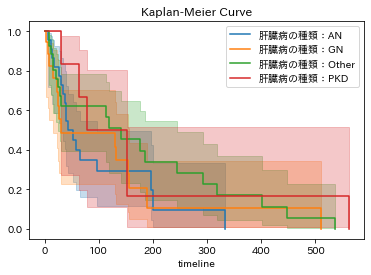

In [47]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
ax = None
for name, group in df.groupby("disease"):
    kmf.fit(group["time"], event_observed=group["status"],
            label="肝臓病の種類：" + str(name))
    if ax is None:
        ax = kmf.plot()
    else:
        ax = kmf.plot(ax=ax)
plt.title("Kaplan-Meier Curve")
plt.show()

In [48]:
def cox_lasso(X, y, delta, lam):
    delta[0] = 1
    n = len(y)
    w = np.zeros(n)
    u = np.zeros(n)
    pi = np.zeros((n, n))
    beta = np.random.randn(p)
    gamma = np.zeros(p)
    while np.sum((beta - gamma)**2) > 10**(-4):
        beta = gamma.copy()
        s = np.dot(X, beta)
        v = np.exp(s)
        for i in range(n):
            for j in range(n):
                pi[i, j] = v[i] / np.sum(v[j:n])
        for i in range(n):
            u[i] = delta[i]
            w[i] = 0
            for j in range(i+1):
                if delta[j] == 1:
                    u[i] = u[i] - pi[i, j]
                    w[i] = w[i] + pi[i, j] * (1 - pi[i, j])
            z = s + u / w
        W = np.diag(w)
        print(gamma)
        gamma0, gamma = W_linear_lasso(X, z, W, lam=lam)
    return gamma

### 例22

In [49]:
df = df.sort_values("time")
y = df["time"]
p = 4
delta = df["status"]
X = df[["age", "sex", "disease", "frail"]].copy()
size_mapping = {"GN": 1, "AN": 2, "PKD": 3, "Other": 0}
X["disease"] = df["disease"].map(size_mapping)
X = np.array(X)
y = np.array(y)
delta = np.array(delta)
cox_lasso(X, y, delta, 0)

[0. 0. 0. 0.]
[ 0.010432   -1.71518832 -0.37390345  1.33716878]
[ 0.01478213 -1.64157246 -0.40155686  1.37863492]
[ 0.01616734 -1.62043703 -0.41091684  1.39632499]
[ 0.01661315 -1.61578004 -0.4142613   1.40464894]


array([ 0.01676301, -1.61572413, -0.41563326,  1.40892236])

In [50]:
cox_lasso(X, y, delta, 0.1)

[0. 0. 0. 0.]
[ 0.         -1.00021319 -0.07583775  0.99765711]
[ 0.         -0.93830037 -0.0471629   0.96658923]
[ 0.         -0.91900008 -0.04067863  0.9537008 ]


array([ 0.        , -0.91340382, -0.03929811,  0.94878576])

In [51]:
cox_lasso(X, y, delta, 0.2)

[0. 0. 0. 0.]
[ 0.         -0.51061984 -0.          0.72069946]
[ 0.         -0.48841277 -0.          0.68736493]


array([ 0.        , -0.48432671, -0.        ,  0.67844288])

### 例23

In [ ]:
# Linuxでの実行（Windows, Google Colaboratory不可）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glmnet_python
from glmnet import glmnet
from glmnetCoef import glmnetCoef
import sys
from cvglmnet import cvglmnet
from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot
import os
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from lifelines import KaplanMeierFitter

In [ ]:
# Linuxでの実行（windows, Google Colaboratory不可）
# 最適な係数を求める（7339個中29個のみが非ゼロ）
base = importr("base")
base.load("LymphomaData.rda")
w = robjects.globalenv["patient.data"]
X = np.array(w[0]).T
y = np.array(w[1])
delta = np.array(w[2])
w = np.concatenate([y.reshape(240, 1), delta.reshape(240, 1)], axis=1)
fit = glmnet(x=X.copy(), y=w.copy(), family="cox")
beta = glmnetCoef(fit, s=np.float64([0.119787]))
print(np.sum(beta != 0))

In [ ]:
# Linuxでの実行（Windows, Google Colaboratory不可）
# Kaplan-Meier曲線を描く
z = np.sign(np.dot(X, beta))
df2 = pd.DataFrame(
    np.concatenate(
        [y.reshape(240, 1), delta.reshape(240, 1), z], axis=1))
df2.columns = ["time", "status", "sign"]
fig = plt.figure()
kmf = KaplanMeierFitter()
ax = None
for name, group in df2.groupby("sign"):
    kmf.fit(group["time"], event_observed=group["status"],
            label="z = " + str(name))
    if ax is None:
        ax = kmf.plot()
    else:
        ax = kmf.plot(ax=ax)

In [ ]:
plt.title("Kaplan-Meier Curve")
fig.savefig("img7.png")